# Obecná audio podobnost

## MFCC deskriptor + DTW distance

In [257]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from dtw import dtw, accelerated_dtw
from numpy.linalg import norm
import numpy as np
import math
import time

### Extract MFCC feature

In [273]:
def extract_mfcc(file):
    signal, sr = librosa.load('data/' + file)
    mfcc = librosa.feature.mfcc(signal, n_mfcc=13, sr=sr)
    return mfcc

### Split one audio track into multiple samples

In [306]:
N = 400 # Sample size

def split_mfcc(mfcc):
    n_samples = math.floor(mfcc.shape[1] / SAMPLE_SIZE)
    last_sample_size = mfcc.shape[1] % SAMPLE_SIZE
#    print('Splitting into %d samples of size %d. Last sample has size %d.' % (n_samples, SAMPLE_SIZE, last_sample_size))
    
    samples = []
    for i in range(n_samples):
        samples.append(mfcc[:, i*N:(i+1)*N])
    samples.append(mfcc[:, n_samples*N:])
    
    return samples

### Build reference database of audio samples

In [299]:
def build_db(files):
    db = []
    
    for file in files:
        mfcc = extract_mfcc(file)
        samples = split_mfcc(mfcc)

        for sample in samples:
            db.append({ 'file': file, 'mfcc': sample })
    
    print("Added %d samples of %d audiotracks" % (len(db), len(files)))
    return np.array(db, dtype=object)

### Distance measure

In [300]:
def distance(a, b):
    dist, cost, acc_cost, path = dtw(a.T, b.T, dist=lambda x, y: norm(x - y, ord=1))
    return dist

### Find the most similar match

In [301]:
def find_match(mfcc, db):
    start = time.time()
    matches = []
    
    # Loop over all samples in the database and find the best match
    for sample in db:
        dist = None
        
        # Align both samples to the same size
        if mfcc.shape[1] == sample['mfcc'].shape[1]:
            dist = distance(mfcc, sample['mfcc'])
        elif mfcc.shape[1] < sample['mfcc'].shape[1]:
            dist = distance(mfcc, sample['mfcc'][:, mfcc.shape[1]])
        else:
            dist = distance(mfcc[:, sample['mfcc'].shape[1]], sample['mfcc'])
        
        matches.append({ 'file': sample['file'], 'dist': dist })

    matches = sorted(matches, key=lambda x: x['dist'])
    print("Time: %.2f s" % (time.time() - start))
    return matches

### Run

In [307]:
files = ['sample_1.wav', 'dubstep_beat_1.wav', 'dubstep_drum.mp3', 'trance.m4a']
db = build_db(files)

/usr/local/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Added 6 samples of 4 audiotracks


In [308]:
mfcc = extract_mfcc('recorded_sample_1.m4a')[:, :N]
find_match(mfcc, db)

/usr/local/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Time: 4.62 s


[{'file': 'sample_1.wav', 'dist': 35945.62905883789},
 {'file': 'dubstep_beat_1.wav', 'dist': 86426.36378479004},
 {'file': 'sample_1.wav', 'dist': 119476.18923950195},
 {'file': 'trance.m4a', 'dist': 148126.52734375},
 {'file': 'dubstep_drum.mp3', 'dist': 149414.47550964355},
 {'file': 'dubstep_beat_1.wav', 'dist': 209982.72225952148}]

In [310]:
mfcc = extract_mfcc('trance_2.m4a')[:, :N]
find_match(mfcc, db)

/usr/local/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Time: 4.61 s


[{'file': 'sample_1.wav', 'dist': 37445.249908447266},
 {'file': 'dubstep_beat_1.wav', 'dist': 85355.85360717773},
 {'file': 'trance.m4a', 'dist': 141331.39974975586},
 {'file': 'dubstep_drum.mp3', 'dist': 149616.13061523438},
 {'file': 'sample_1.wav', 'dist': 152272.89219665527},
 {'file': 'dubstep_beat_1.wav', 'dist': 178349.8076171875}]

## Experiments

In [141]:
y1, sr1 = librosa.load('data/sample_1.wav')
y2, sr2 = librosa.load('data/dubstep_beat_1.wav')
y3, sr3 = librosa.load('data/dubstep_drum.mp3')
y4, sr4 = librosa.load('data/recorded_sample_1.m4a')

/usr/local/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


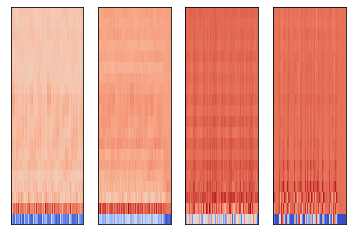

In [142]:
#Showing multiple plots using subplot
plt.subplot(1, 4, 1) 
mfcc1 = librosa.feature.mfcc(y1,sr1)   #Computing MFCC values
librosa.display.specshow(mfcc1)

plt.subplot(1, 4, 2)
mfcc4 = librosa.feature.mfcc(y4, sr4)
librosa.display.specshow(mfcc4)

plt.subplot(1, 4, 3)
mfcc2 = librosa.feature.mfcc(y2, sr2)
librosa.display.specshow(mfcc2)

plt.subplot(1, 4, 4)
mfcc3 = librosa.feature.mfcc(y3, sr3)
librosa.display.specshow(mfcc3)

In [143]:
mfcc4 = mfcc4[:, 50:200]
mfcc4.shape

(20, 150)

In [144]:
mfcc1 = mfcc1[:, :mfcc4.shape[1]]
mfcc1.shape

(20, 150)

In [145]:
dist, cost, acc_cost, path = dtw(mfcc1.T, mfcc4.T, dist=lambda x, y: norm(x - y, ord=1))
print('Normalized distance between the two sounds:', dist)

Normalized distance between the two sounds: 67012.24461364746


In [81]:
dist, cost, acc_cost, path = dtw(mfcc3.T, mfcc2.T, dist=lambda x, y: norm(x - y, ord=1))
print('Normalized distance between the two sounds:', dist)

Normalized distance between the two sounds: 124291.7311706543


## Fingerprinting

In [13]:
import acoustid

In [14]:
duration1, fingerprint1 = acoustid.fingerprint_file('data/dubstep_beat_1.wav')

NoBackendError: fpcalc not found

In [10]:
duration2, fingerprint2 = acoustid.fingerprint_file('data/dubstep_drum.mp3')

In [82]:
popcnt_table_8bit = [
    0,1,1,2,1,2,2,3,1,2,2,3,2,3,3,4,1,2,2,3,2,3,3,4,2,3,3,4,3,4,4,5,
    1,2,2,3,2,3,3,4,2,3,3,4,3,4,4,5,2,3,3,4,3,4,4,5,3,4,4,5,4,5,5,6,
    1,2,2,3,2,3,3,4,2,3,3,4,3,4,4,5,2,3,3,4,3,4,4,5,3,4,4,5,4,5,5,6,
    2,3,3,4,3,4,4,5,3,4,4,5,4,5,5,6,3,4,4,5,4,5,5,6,4,5,5,6,5,6,6,7,
    1,2,2,3,2,3,3,4,2,3,3,4,3,4,4,5,2,3,3,4,3,4,4,5,3,4,4,5,4,5,5,6,
    2,3,3,4,3,4,4,5,3,4,4,5,4,5,5,6,3,4,4,5,4,5,5,6,4,5,5,6,5,6,6,7,
    2,3,3,4,3,4,4,5,3,4,4,5,4,5,5,6,3,4,4,5,4,5,5,6,4,5,5,6,5,6,6,7,
    3,4,4,5,4,5,5,6,4,5,5,6,5,6,6,7,4,5,5,6,5,6,6,7,5,6,6,7,6,7,7,8,
]

def popcnt(x):
    """
    Count the number of set bits in the given 32-bit integer.
    """
    return (popcnt_table_8bit[(x >>  0) & 0xFF] +
            popcnt_table_8bit[(x >>  8) & 0xFF] +
            popcnt_table_8bit[(x >> 16) & 0xFF] +
            popcnt_table_8bit[(x >> 24) & 0xFF])

In [83]:
def compare_fingerprints(fp1, fp2):
    error = 0
    for x, y in zip(fp1, fp2):
        error += popcnt(x ^ y)
    print(1.0 - error / 32.0 / min(len(fp1), len(fp2)))

In [84]:
fingerprint1

NameError: name 'fingerprint1' is not defined

In [85]:
fpcalc_out="FINGERPRINT=1097131814,1097099559,1365727511,1365661973,1365661957,1366711749,1364641157,1398194565,1398194565,1398199175,1406583687,1408680903,1374012262,1373946150,1365566758,1348756790,1348951318,1348951319,1348885783,1432769815,1432831255,1165391175,1163281863,1163314631,1163314631,1163380215,1163183463,1163191655,1163392263,1165481239,1165350263,1198810471,1196914007,1196836295,1196934615,1196742053,1196746165,1196946839,1196938647,1196937623,1196814743,1196814807,1199002391,1098348311,1097301815,1097088805,1097083237,1365536229,1400329605,1398198661,1381417349,1138147719,1140245127,1135002439,1105511206,1105512230,1097101095,1097292063,1097292053,1130780949,1130781125,1131826565,1129760133,1398260101,1398198661,1398198663,1375126151,1369883607,1373946662,1373955878,1348792102,1348984086,1348951319,1348885767,1415992599,1432765719,1433826631,1163281863,1163281863,1163314631,1171768791,1163183463,1163191655,1163388183,1165415687,1165481335,1198847335,1198875991,1196840263"
fpcalc_out2="FINGERPRINT=1699902959,1701988079,1710444271,1706118879,1706098375,1708191303,1741745935,1733422367,1733424159,1733555231,1733554207,1729319039,1729196287,1697870335,1702000623,1710378735,1710444287,1706127071,1706094287,1708191311,1708191503,1733424415,1733424191,1733424191,1733554239,1729359999,1695764735,1695774207,1702000623,1710378735,1710444271,1706151639,1710288455,1708191303,1741745935,1733424415,1733424191"

In [86]:
fingerprint_index = fpcalc_out.find('FINGERPRINT=') + 12

In [87]:
fp1 = list(map(int, fpcalc_out[fingerprint_index:].split(',')))
fp2 = list(map(int, fpcalc_out2[fingerprint_index:].split(',')))

In [90]:
compare_fingerprints(fp1, fp2)

0.5793918918918919


### Otázky
 - Jak kombinovat více deskriptorů?
 - Co s různou délkou souborů? Co když je nahrávka uprostřed toho druhého songu?
 - Co s výkonností u porovnávání deskriptorů?
